This is my second attempt at trying to perform preprocessing on PPG data to get clean values. This dataset was obtained [**here**](https://www.kaggle.com/datasets/krishd123/ppg-collection-for-cognitive-strain). This script works loads the data from the dataset, implements a moving average filter to detrend the signal, a bandpass filter, a standard scaler to normalize the signal, and uses EMD (Empirical Mode Decomposition) to separate the PPG signal into different intermediate IMFs (Intrisic Mode Functions) for easier analysis.

In [93]:
#Initial Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert, butter, filtfilt, find_peaks
from scipy.stats import skew
from pyemd import EMD
from sklearn.preprocessing import StandardScaler

In [94]:
# Load data
data_file_low = pd.read_csv("Data/PPG for Cognitive Strain/Low_MWL/Low_MWL/p3l.csv")
data_file_high = pd.read_csv("Data/PPG for Cognitive Strain/High_MWL/High_MWL/p3h.csv")

# Extract PPG signals
signal_low = data_file_low['Trial 1:0back'].values
signal_high = data_file_high['Trial 3:3back'].values

# Sampling rate
sampling_rate = 256

In [95]:
#Defining utility functions for the preprocessing
def detrend_signal(signal, window=256):
    moving_average = np.convolve(signal, np.ones(window)/window, mode='same')
    detrended_signal = signal - moving_average
    return detrended_signal

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.4 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

def normalize_signal(signal):
    scaler = StandardScaler()
    signal_normalized = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    return signal_normalized

def detect_peaks(signal, distance=150):
    peaks, _ = find_peaks(signal, distance=distance)
    return peaks

def instant_phase(imfs):
    analytic_signal = hilbert(imfs)
    phase = np.unwrap(np.angle(analytic_signal))
    return phase

In [96]:
#Full preprocessing pipeline
def preprocess_signal(signal, sampling_rate):
    # Detrend
    signal_detrended = detrend_signal(signal)
    
    # Bandpass filter
    signal_filtered = bandpass_filter(signal_detrended, 0.5, 4.0, sampling_rate)
    
    # Normalize
    signal_normalized = normalize_signal(signal_filtered)
    
    # EMD
    emd = EMD()
    imfs = emd(signal_normalized)
    
    # Peak detection
    peaks = detect_peaks(signal_normalized)
    
    return signal_normalized, imfs, peaks

In [97]:
#Function to plot IMFs
def plot_imfs(imfs, title):
    n_imfs = imfs.shape[0]
    plt.figure(figsize=(12, 2 * n_imfs))
    for i in range(n_imfs):
        plt.subplot(n_imfs, 1, i + 1)
        plt.plot(imfs[i])
        plt.title(f'{title} - IMF {i+1}')
        plt.tight_layout()
    plt.show()

In [98]:
# Function to plot the original and processed signals side by side
def plot_signal_comparison(original_signal, preprocessed_signal, start, end, title):
    time_axis = np.arange(start, end) / sampling_rate
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, original_signal[start:end], label='Original Signal', color='blue')
    plt.plot(time_axis, preprocessed_signal[start:end], label='Preprocessed Signal', color='red')
    plt.title(f'{title} - Signal Comparison')
    plt.xlabel('Time (s)')
    plt.ylabel('PPG Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [99]:
# Apply preprocessing
signal_low_preprocessed, imfs_low, peaks_low = preprocess_signal(signal_low, sampling_rate)
signal_high_preprocessed, imfs_high, peaks_high = preprocess_signal(signal_high, sampling_rate)

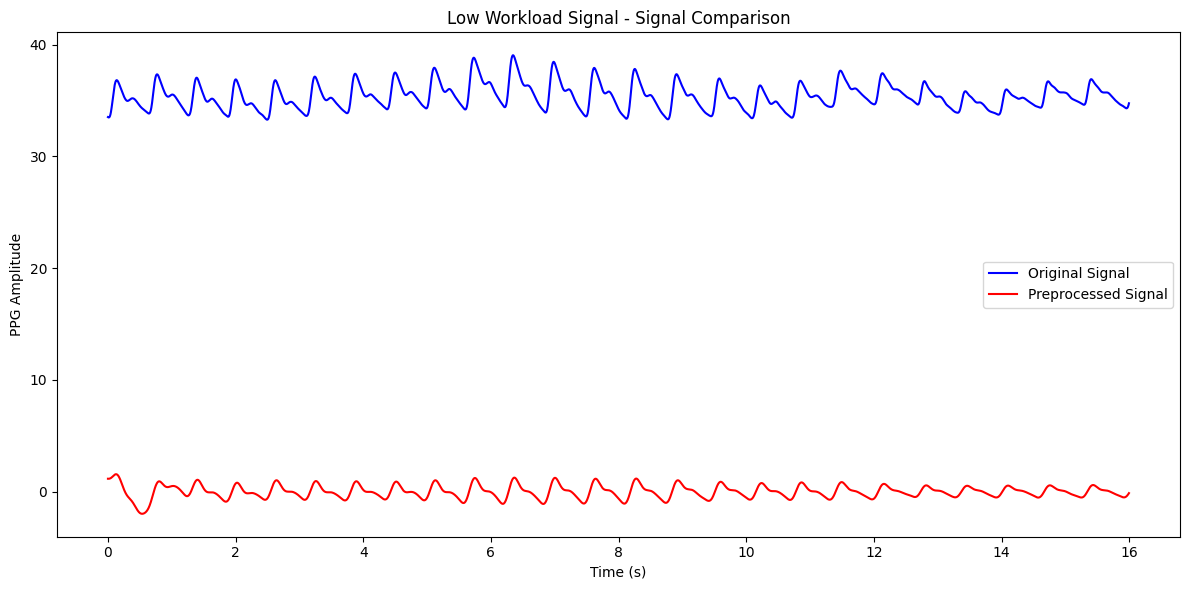

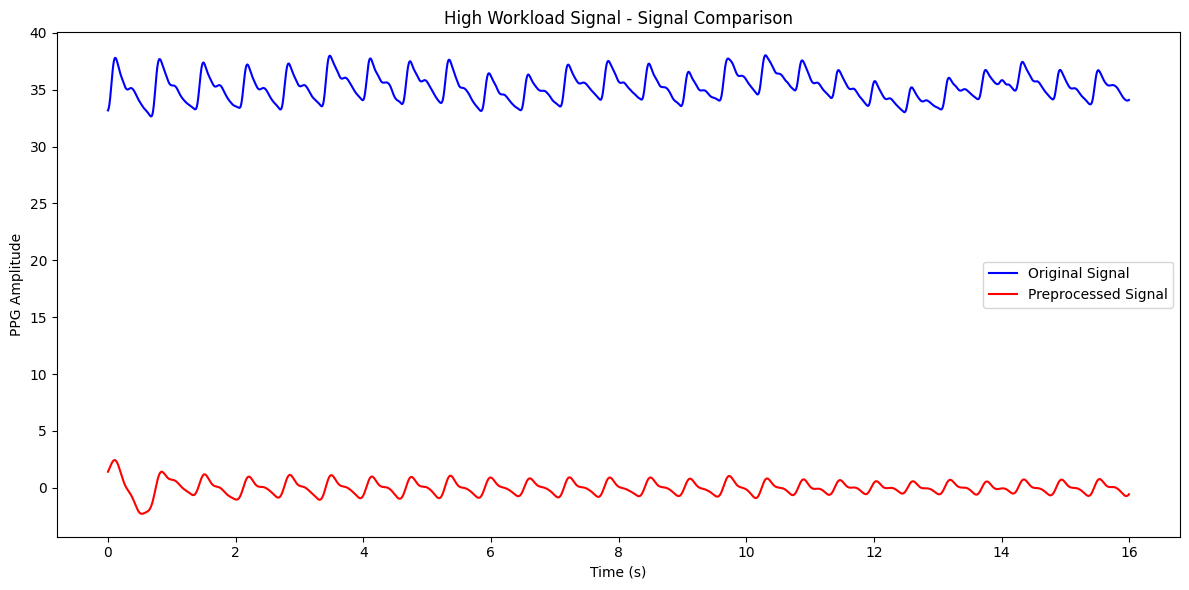

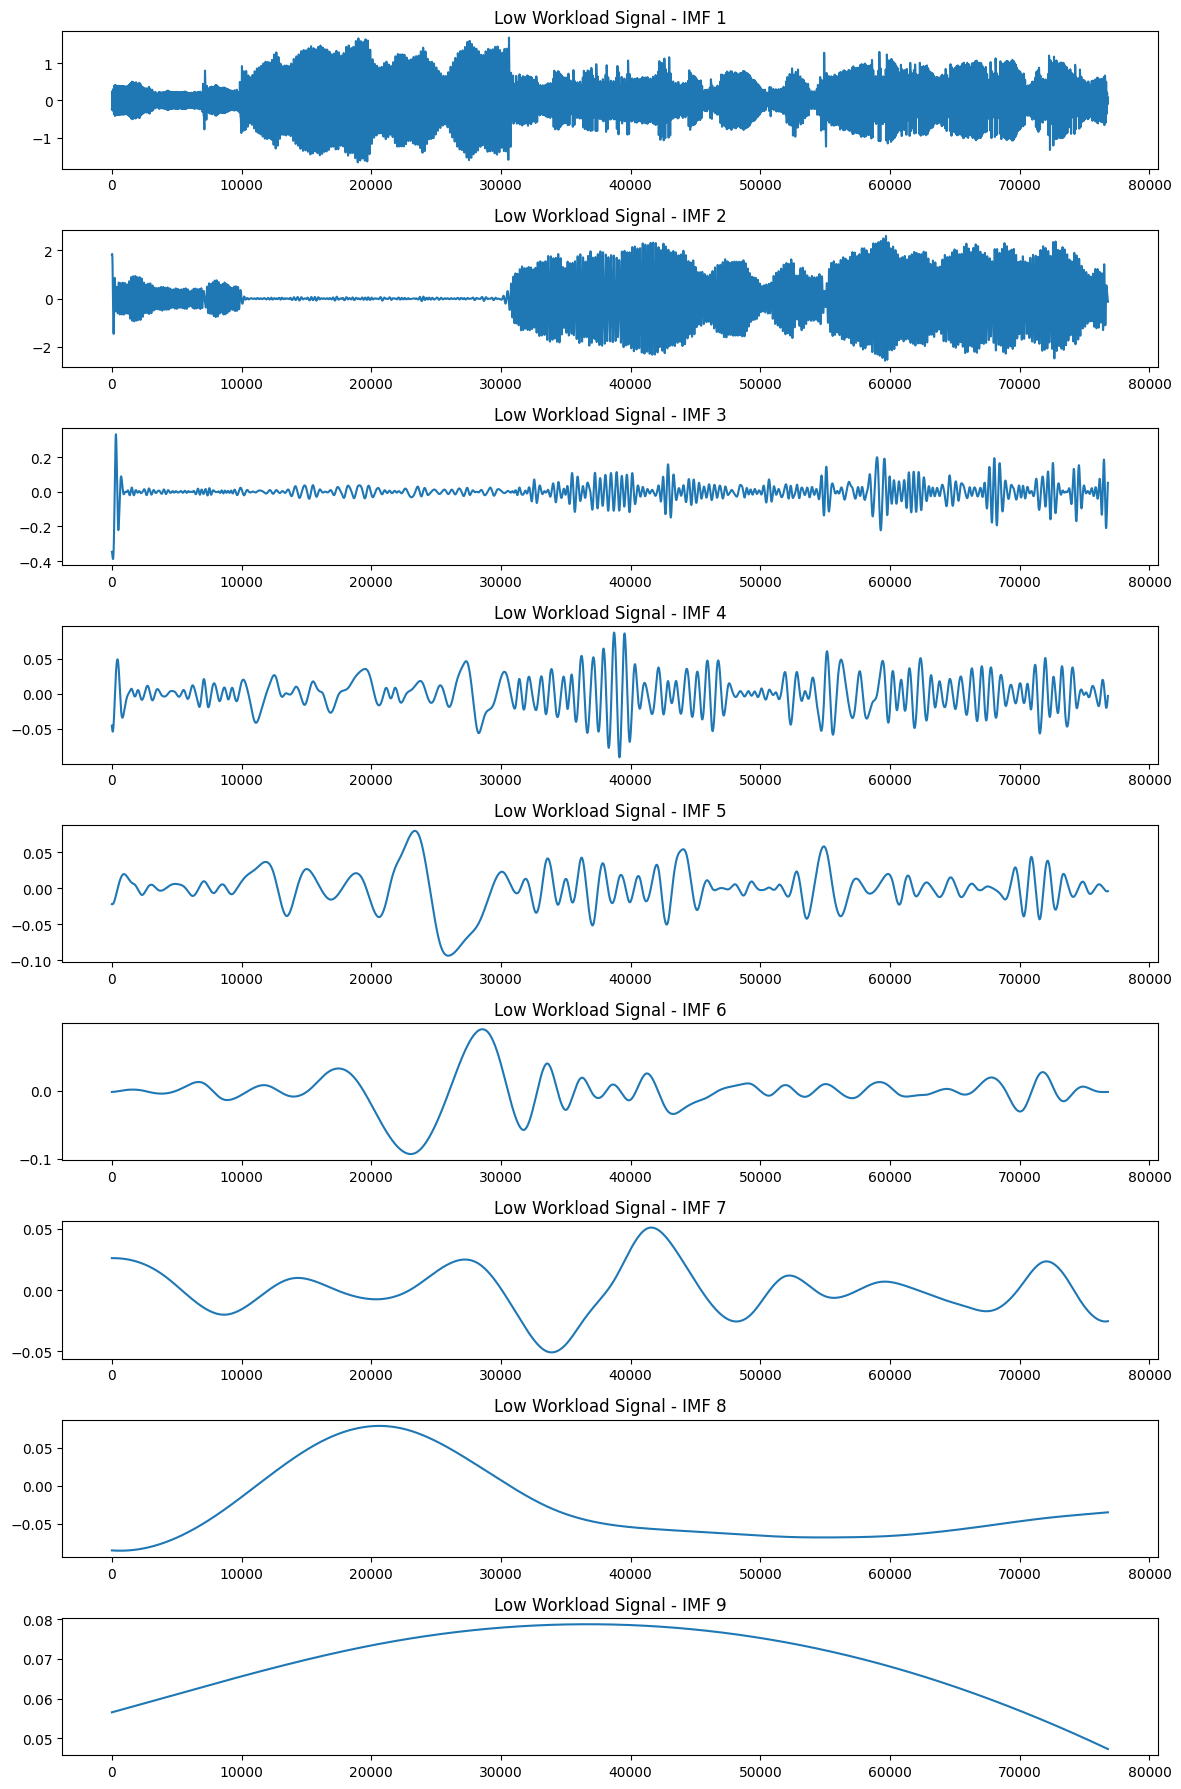

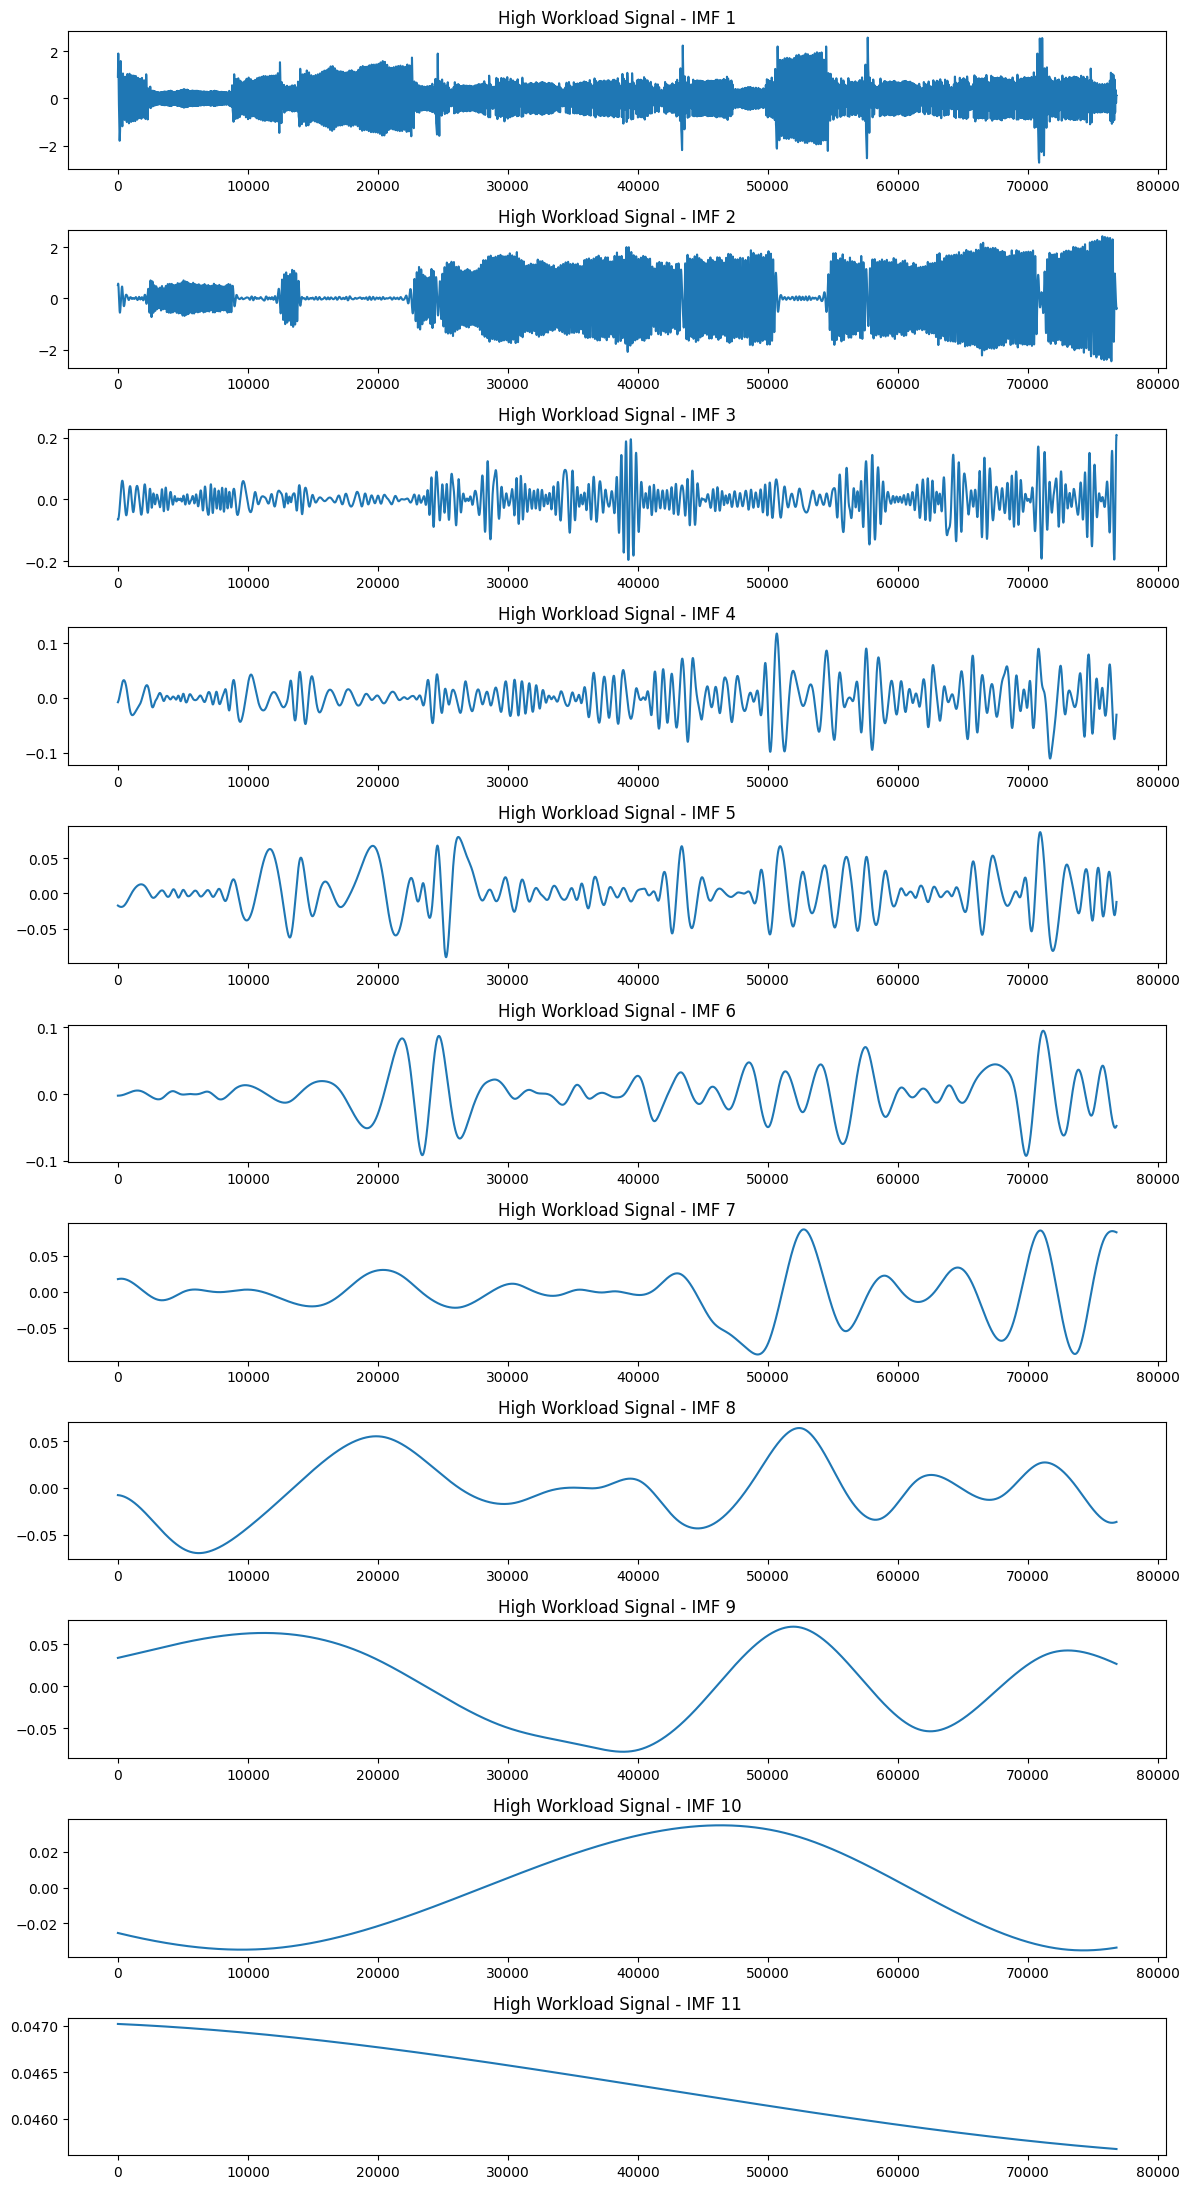

In [100]:
#Choosing a small segment of the signal to illustrate comparison
segment_start = 0
segment_end = 4096

# Plot comparisons for low and high workload signals
plot_signal_comparison(signal_low, signal_low_preprocessed, segment_start, segment_end, "Low Workload Signal")
plot_signal_comparison(signal_high, signal_high_preprocessed, segment_start, segment_end, "High Workload Signal")

# Plot IMFs for low and high workload signals
plot_imfs(imfs_low, "Low Workload Signal")
plot_imfs(imfs_high, "High Workload Signal")